## UNSEEN via seasonal mean relationships ##

Trying something slightly different. On a seasonal (e.g. ONDJFM) mean timescale, there are likely to be fairly strong relationships between wind speed and wind power generation, temperature and demand, and irradiance and solar power generation. It therefore stands to reason that a combination of these variables, used with a multi linear regression, could project onto the seasonal mean demand net wind (or demand net renewables). Where we have an observed (hopefully linear) relationship between the surface variables and demand net wind (or demand net renewables), we can extrapolate this so that "worse" (i.e. lower wind speeds, colder temperatures, more dull conditions) conditions produced by DePreSys can map onto worse impacts for demand net wind (or demand net renewables). 

Steps for this:

1. Load in the CLEARHEADS dataset and process into demand net wind (+ demand net renewables), along with the surface variables for the different countries (maybe just UK first).
2. Create scatter plots of the relationship between seasonal mean variables (e.g. 10m wind speed/100m wind speed) and the energy system variable (e.g. wind power generation).
3. Create scatter plots for how the individual seasonal mean variables map onto demand net wind/demand net renewables.
4. Create a multi linear regression for mapping the combination of individual surface variables onto demand net wind/demand net renewables.

In [1]:
# Import local modules
import os
import sys
import glob
import time

# Import third-party modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Specific imports
from tqdm import tqdm

In [2]:
# Set up the directory where the clearhedas data are stored
data_dir = '/home/users/benhutch/CLEARHEADS_EU_Power_Data'

# List the clearheads data files
files = os.listdir(data_dir)

files

['EEZ_zones_wp_historical.nc',
 'NUTS_0_CDD_historical_pop_weighted.nc',
 'NUTS_0_HDD_historical_pop_weighted.nc',
 'NUTS_0_sp_historical.nc',
 'NUTS_0_sp_historical_loc_weighted.nc',
 'NUTS_0_speed100m_historical.nc',
 'NUTS_0_speed10m_historical.nc',
 'NUTS_0_speed10m_historical_pop_weighted.nc',
 'NUTS_0_ssrd_historical.nc',
 'NUTS_0_ssrd_historical_pop_weighted.nc',
 'NUTS_0_t2m_detrended_timeseries_historical.nc',
 'NUTS_0_t2m_detrended_timeseries_historical_pop_weighted.nc',
 'NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ofs_sim_1_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc',
 'NUTS_0_wp_ons_sim_1_historical_loc_weighted.nc',
 'NUTS_1_sp_historical.nc',
 'NUTS_1_speed100m_historical.nc',
 'NUTS_1_speed10m_historical.nc',
 'NUTS_1_ssrd_historical.nc',
 'NUTS_1_t2m_detrended_timeseries_historical.nc',
 'NUTS_1_wp_historical.nc',
 'NUTS_2_sp_historical.nc',
 'NUTS_2_speed100m_historical.nc',
 'NUTS_2_speed10m_historical.nc',
 'NUTS_2

In [3]:
# Create a list of the files to extract
files_to_extract = [
    "NUTS_0_sp_historical.nc",
    "NUTS_0_speed100m_historical.nc",
    "NUTS_0_speed10m_historical.nc",
    "NUTS_0_ssrd_historical.nc",
    "NUTS_0_wp_ofs_sim_0_historical_loc_weighted.nc",
    "NUTS_0_wp_ons_sim_0_historical_loc_weighted.nc",
]

# Create a list with the names
names = [
    "solar_power",
    "100m_wind_speed",
    "10m_wind_speed",
    "solar_irradiance",
    "ofs_cfs",
    "ons_cfs",
]

In [4]:
# Set up an empty dataframe to store the data
df_full = pd.DataFrame()

# Loop over the files to extract
for file, name in tqdm(zip(files_to_extract, names)):
    # Load the data
    file_path = os.path.join(data_dir, file)

    # assert that the file exists
    assert os.path.exists(file_path), f"File {file_path} does not exist"

    # Load the data
    ds = xr.open_dataset(file_path)

    # # print ds.variables
    # print(ds.variables)

    # assert that NUTS_keys is in the variables
    assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

    # extract the nuts keys
    nuts_keys = ds["NUTS_keys"].values

    # turn the data into a dataframe
    df = ds.to_dataframe()

    # Pivot the dataframe
    df_pivot = df.reset_index().pivot(
        index="time_in_hours_from_first_jan_1950",
        columns="NUTS",
        values="timeseries_data",
    )

    # set the columns as the nuts keys
    df_pivot.columns = nuts_keys

    # Convert 'time_in_hours_from_first_jan_1950' column to datetime
    df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

    # constrain to the "UK" column
    df_pivot = df_pivot["UK"]

    # if this is the first iteration, set the index
    if df_full.empty:
        df_full = df_pivot.to_frame(name=name)
    else:
        df_full[name] = df_pivot

    # print the head of the dataframe
    print(df_full.head())

    # sys.exit()

0it [00:00, ?it/s]

1it [00:07,  7.10s/it]

                                   solar_power
time_in_hours_from_first_jan_1950             
1950-01-01 00:00:00                        0.0
1950-01-01 01:00:00                        0.0
1950-01-01 02:00:00                        0.0
1950-01-01 03:00:00                        0.0
1950-01-01 04:00:00                        0.0


2it [00:13,  6.90s/it]

                                   solar_power  100m_wind_speed
time_in_hours_from_first_jan_1950                              
1950-01-01 00:00:00                        0.0         6.148996
1950-01-01 01:00:00                        0.0         6.156016
1950-01-01 02:00:00                        0.0         6.138777
1950-01-01 03:00:00                        0.0         6.390699
1950-01-01 04:00:00                        0.0         6.461800


3it [00:20,  6.96s/it]

                                   solar_power  100m_wind_speed  \
time_in_hours_from_first_jan_1950                                 
1950-01-01 00:00:00                        0.0         6.148996   
1950-01-01 01:00:00                        0.0         6.156016   
1950-01-01 02:00:00                        0.0         6.138777   
1950-01-01 03:00:00                        0.0         6.390699   
1950-01-01 04:00:00                        0.0         6.461800   

                                   10m_wind_speed  
time_in_hours_from_first_jan_1950                  
1950-01-01 00:00:00                      3.976531  
1950-01-01 01:00:00                      3.948778  
1950-01-01 02:00:00                      3.957120  
1950-01-01 03:00:00                      4.150732  
1950-01-01 04:00:00                      4.243430  


4it [00:27,  7.02s/it]

                                   solar_power  100m_wind_speed  \
time_in_hours_from_first_jan_1950                                 
1950-01-01 00:00:00                        0.0         6.148996   
1950-01-01 01:00:00                        0.0         6.156016   
1950-01-01 02:00:00                        0.0         6.138777   
1950-01-01 03:00:00                        0.0         6.390699   
1950-01-01 04:00:00                        0.0         6.461800   

                                   10m_wind_speed  solar_irradiance  
time_in_hours_from_first_jan_1950                                    
1950-01-01 00:00:00                      3.976531               0.0  
1950-01-01 01:00:00                      3.948778               0.0  
1950-01-01 02:00:00                      3.957120               0.0  
1950-01-01 03:00:00                      4.150732               0.0  
1950-01-01 04:00:00                      4.243430               0.0  


5it [00:30,  5.54s/it]

                                   solar_power  100m_wind_speed  \
time_in_hours_from_first_jan_1950                                 
1950-01-01 00:00:00                        0.0         6.148996   
1950-01-01 01:00:00                        0.0         6.156016   
1950-01-01 02:00:00                        0.0         6.138777   
1950-01-01 03:00:00                        0.0         6.390699   
1950-01-01 04:00:00                        0.0         6.461800   

                                   10m_wind_speed  solar_irradiance   ofs_cfs  
time_in_hours_from_first_jan_1950                                              
1950-01-01 00:00:00                      3.976531               0.0  0.126081  
1950-01-01 01:00:00                      3.948778               0.0  0.132902  
1950-01-01 02:00:00                      3.957120               0.0  0.149275  
1950-01-01 03:00:00                      4.150732               0.0  0.163094  
1950-01-01 04:00:00                      4.243430 

6it [00:33,  5.62s/it]

                                   solar_power  100m_wind_speed  \
time_in_hours_from_first_jan_1950                                 
1950-01-01 00:00:00                        0.0         6.148996   
1950-01-01 01:00:00                        0.0         6.156016   
1950-01-01 02:00:00                        0.0         6.138777   
1950-01-01 03:00:00                        0.0         6.390699   
1950-01-01 04:00:00                        0.0         6.461800   

                                   10m_wind_speed  solar_irradiance   ofs_cfs  \
time_in_hours_from_first_jan_1950                                               
1950-01-01 00:00:00                      3.976531               0.0  0.126081   
1950-01-01 01:00:00                      3.948778               0.0  0.132902   
1950-01-01 02:00:00                      3.957120               0.0  0.149275   
1950-01-01 03:00:00                      4.150732               0.0  0.163094   
1950-01-01 04:00:00                      4.2

In [5]:
df_full.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs
time_in_hours_from_first_jan_1950,,,,,,
1950-01-01 00:00:00,0.0,6.148996,3.976531,0.0,0.126081,0.150885
1950-01-01 01:00:00,0.0,6.156016,3.948778,0.0,0.132902,0.169805
1950-01-01 02:00:00,0.0,6.138777,3.957120,0.0,0.149275,0.195890
1950-01-01 03:00:00,0.0,6.390699,4.150732,0.0,0.163094,0.235261
1950-01-01 04:00:00,0.0,6.461800,4.243430,0.0,0.160107,0.261474


In [6]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 0

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot["UK"]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_no_detrend")
else:
    df_full["t2m_no_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)>
[5 values with dtype=float32]
Dimensions without coordinates: trend
4


In [7]:
# import the temperature data with different levels of detrending
file_path = os.path.join(data_dir, "NUTS_0_t2m_detrended_timeseries_historical.nc")

# assert that the file exists
assert os.path.exists(file_path), f"File {file_path} does not exist"

# Load the data
ds = xr.open_dataset(file_path)

# # print ds.variables
# print(ds.variables)

# assert that NUTS_keys is in the variables
assert "NUTS_keys" in ds.variables, f"Variable NUTS_keys not found in {file_path}"

# extract the nuts keys
nuts_keys = ds["NUTS_keys"].values

# trend levle = [1950., 1980., 2010., 2020.,    0.]

# Select the level of detrending
# print the trend_levels variable
print(ds["trend_levels"])

trend_level = 2020

# select 0 detrend
# extract the trend levels
trend_levels = ds.trend_levels.values

# Find the index of the trend level
idx = np.where(trend_levels == trend_level)[0][0]

# print the index
print(idx)

# Extract the data
ds = ds.isel(trend=idx)

# turn the data into a dataframe
df = ds.to_dataframe()

# Pivot the dataframe
df_pivot = df.reset_index().pivot(
    index="time_in_hours_from_first_jan_1950",
    columns="NUTS",
    values="detrended_data",
)

# set the columns as the nuts keys
df_pivot.columns = nuts_keys

# Convert 'time_in_hours_from_first_jan_1950' column to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, unit="h", origin="1950-01-01")

# constrain to the "UK" column
df_pivot = df_pivot["UK"]

# if this is the first iteration, set the index
if df_full.empty:
    df_full = df_pivot.to_frame(name="t2m_2020_detrend")
else:
    df_full["t2m_2020_detrend"] = df_pivot

<xarray.DataArray 'trend_levels' (trend: 5)>
[5 values with dtype=float32]
Dimensions without coordinates: trend
3


In [8]:
df_full.head()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend
time_in_hours_from_first_jan_1950,,,,,,,,
1950-01-01 00:00:00,0.0,6.148996,3.976531,0.0,0.126081,0.150885,4.428690,5.895898
1950-01-01 01:00:00,0.0,6.156016,3.948778,0.0,0.132902,0.169805,4.583863,6.051068
1950-01-01 02:00:00,0.0,6.138777,3.957120,0.0,0.149275,0.195890,4.598047,6.065250
1950-01-01 03:00:00,0.0,6.390699,4.150732,0.0,0.163094,0.235261,4.460886,5.928087
1950-01-01 04:00:00,0.0,6.461800,4.243430,0.0,0.160107,0.261474,4.640312,6.107510


In [9]:
# path to demand data
path="/home/users/benhutch/energy-sotcr-2023/data/ERA5_UK_1940_2024_daily_SP_WP_demand_wind.csv"

# impoet this df
df_demand = pd.read_csv(path)

In [10]:
df_demand.head()

,date,United_Kingdom_solar_cf,United_Kingdom_wind_cf,United_Kingdom_demand,United_Kingdom_wd_demand,UK_wind_speed,UK_temp,United_Kingdom_wind_gen,demand_net_wind,wd_demand_net_wind
0,1940-01-01,0.016125,0.344934,46.420023,47.228293,6.961509,-0.688529,10.217639,36.202385,37.010655
1,1940-01-02,0.013857,0.235733,47.953306,47.953306,5.675701,-1.658305,6.982887,40.970419,40.970419
2,1940-01-03,0.093672,0.386296,47.568234,47.568234,7.631405,-1.143233,11.442862,36.125371,36.125371
3,1940-01-04,0.094658,0.468219,46.787436,46.787436,8.341800,-0.098840,13.869574,32.917862,32.917862
4,1940-01-05,0.111828,0.168710,46.014368,46.914110,5.555250,-0.268279,4.997523,41.016845,41.916587


In [11]:
# subset to United_Kingdom_demand and United_Kingdom_wd_demand
df_demand_subset = df_demand[["date", "United_Kingdom_demand", "United_Kingdom_wd_demand"]]

In [12]:
df_demand_subset.head()

,date,United_Kingdom_demand,United_Kingdom_wd_demand
0,1940-01-01,46.420023,47.228293
1,1940-01-02,47.953306,47.953306
2,1940-01-03,47.568234,47.568234
3,1940-01-04,46.787436,46.787436
4,1940-01-05,46.014368,46.914110


In [13]:
# set date as datetime
df_demand_subset["date"] = pd.to_datetime(df_demand_subset["date"])

# set date as index
df_demand_subset.set_index("date", inplace=True)

/tmp/ipykernel_25268/2338204410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_subset["date"] = pd.to_datetime(df_demand_subset["date"])


In [14]:
# process df_full into daily data
df_full_daily = df_full.resample("D").mean()

In [15]:
#get the min and max date of df_full_daily
min_date = df_full_daily.index.min()
max_date = df_full_daily.index.max()

# subset the demand data to the same date range
df_demand_subset = df_demand_subset.loc[min_date:max_date]

# merge the two dataframes
df_full_daily = pd.concat([df_full_daily, df_demand_subset], axis=1)

In [16]:
df_full_daily.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
2020-12-27,0.023757,8.940444,5.979577,24.189680,0.615395,0.446767,3.649454,3.628710,39.387627,44.078443
2020-12-28,0.018903,5.019287,3.424141,19.100378,0.200217,0.086603,1.774313,1.753511,45.024194,45.832464
2020-12-29,0.020817,7.124440,4.698165,21.119453,0.311446,0.210541,2.592501,2.571643,45.236083,45.236083
2020-12-30,0.023254,5.399757,3.439529,23.473879,0.334843,0.130754,1.594081,1.573165,46.053290,46.053290
2020-12-31,0.023311,6.773319,4.563665,23.496550,0.205502,0.190531,1.811103,1.790130,46.040684,46.040684


In [17]:
#subset to ONDJFM mean
df_full_daily_ONDJFM = df_full_daily[
    (df_full_daily.index.month >= 10) | (df_full_daily.index.month <= 3)
]

# shift the time back by 3 months and take the mean
df_full_daily_ONDJFM = df_full_daily_ONDJFM.shift(-3, freq="M")

# take the annual mean
df_full_daily_ONDJFM = df_full_daily_ONDJFM.resample("Y").mean()

# drop the first and last year
df_full_daily_ONDJFM = df_full_daily_ONDJFM.iloc[1:-1]


/tmp/ipykernel_25268/267130811.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_full_daily_ONDJFM = df_full_daily_ONDJFM.shift(-3, freq="M")
/tmp/ipykernel_25268/267130811.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_full_daily_ONDJFM = df_full_daily_ONDJFM.resample("Y").mean()


In [18]:
# set the index to the year
df_full_daily_ONDJFM.index = df_full_daily_ONDJFM.index.year

In [19]:
df_full_daily_ONDJFM.tail()

,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand
2015,0.045989,8.546028,5.803546,65.247696,0.604229,0.381584,7.051015,7.134888,39.997589,41.452842
2016,0.047428,7.717142,5.185671,80.963707,0.510453,0.312648,6.824999,6.887897,40.287380,41.750628
2017,0.046698,8.437108,5.717490,90.249214,0.604882,0.372400,5.869819,5.911770,40.966321,42.429570
2018,0.046976,8.259077,5.535166,90.075439,0.563557,0.363519,7.054070,7.075075,40.049438,41.512686
2019,0.047315,8.718687,5.897901,100.707596,0.614796,0.402140,6.523098,6.523128,40.475453,41.930705


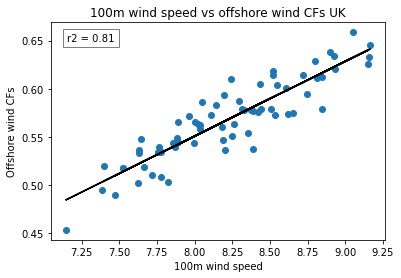

In [20]:
# plot a scttaer between 100m wind speed and ofs_cfs
plt.scatter(df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"])

plt.xlabel("100m wind speed")
plt.ylabel("Offshore wind CFs")

# include a line of best fit
m, b = np.polyfit(
    df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"], 1
)

plt.plot(df_full_daily_ONDJFM["100m_wind_speed"], m * df_full_daily_ONDJFM["100m_wind_speed"] + b, color="k")

# calculate the r2 value
r2 = np.corrcoef(df_full_daily_ONDJFM["100m_wind_speed"], df_full_daily_ONDJFM["ofs_cfs"])[0, 1] ** 2

# text in the top left with r2
plt.text(
    0.05,
    0.95,
    f"r2 = {r2:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# set the title
plt.title("100m wind speed vs offshore wind CFs UK")

plt.show()

In [21]:
def plot_scatter_with_fit(df, x_col, y_col, title, xlabel, ylabel):
    # plot a scatter between x_col and y_col
    plt.scatter(df[x_col], df[y_col])

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # include a line of best fit
    m, b = np.polyfit(df[x_col], df[y_col], 1)

    plt.plot(df[x_col], m * df[x_col] + b, color="k")

    # calculate the r2 value
    r2 = np.corrcoef(df[x_col], df[y_col])[0, 1] ** 2

    # text in the top left with r2
    plt.text(
        0.05,
        0.95,
        f"r2 = {r2:.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # set the title
    plt.title(title)

    plt.show()

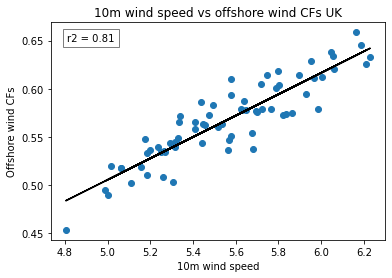

In [22]:
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="ofs_cfs",
    title="10m wind speed vs offshore wind CFs UK",
    xlabel="10m wind speed",
    ylabel="Offshore wind CFs",
)

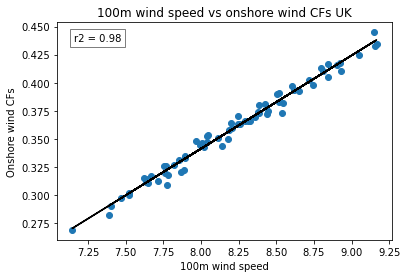

In [23]:
# 100m and onshore wind speed
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="100m_wind_speed",
    y_col="ons_cfs",
    title="100m wind speed vs onshore wind CFs UK",
    xlabel="100m wind speed",
    ylabel="Onshore wind CFs",
)

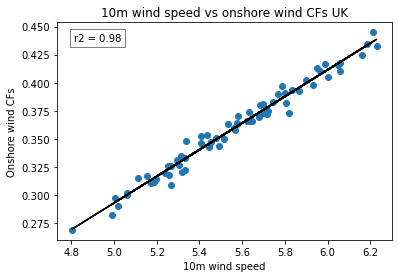

In [24]:
# 10m and onshore wind speed
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="ons_cfs",
    title="10m wind speed vs onshore wind CFs UK",
    xlabel="10m wind speed",
    ylabel="Onshore wind CFs",
)

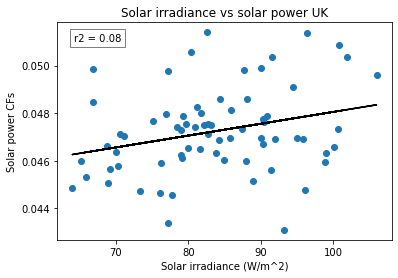

In [25]:
# solar irradiance and solar power cfs
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="solar_irradiance",
    y_col="solar_power",
    title="Solar irradiance vs solar power UK",
    xlabel="Solar irradiance (W/m^2)",
    ylabel="Solar power CFs",
)

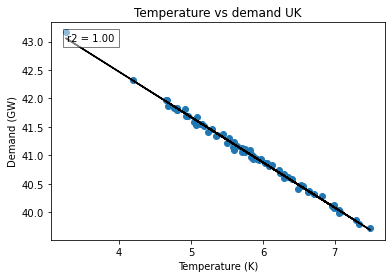

In [26]:
# temperature and demand
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="United_Kingdom_demand",
    title="Temperature vs demand UK",
    xlabel="Temperature (K)",
    ylabel="Demand (GW)",
)

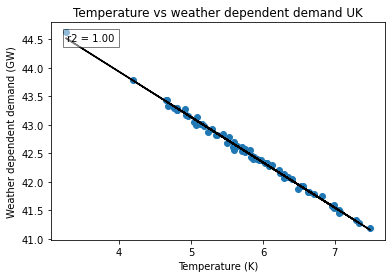

In [27]:
# temperature and weather dependent demand
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="United_Kingdom_wd_demand",
    title="Temperature vs weather dependent demand UK",
    xlabel="Temperature (K)",
    ylabel="Weather dependent demand (GW)",
)

In [28]:
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

In [29]:
# calculate the wind power generation
df_full_daily_ONDJFM["wind_gen"] = (
    installed_ofs_2023 * df_full_daily_ONDJFM["ofs_cfs"]
    + installed_ons_2023 * df_full_daily_ONDJFM["ons_cfs"]
)

In [30]:
# calculate the demand net wind
df_full_daily_ONDJFM["demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

# calculate the weather dependent demand
df_full_daily_ONDJFM["wd_demand_net_wind"] = (
    df_full_daily_ONDJFM["United_Kingdom_wd_demand"] - df_full_daily_ONDJFM["wind_gen"]
)

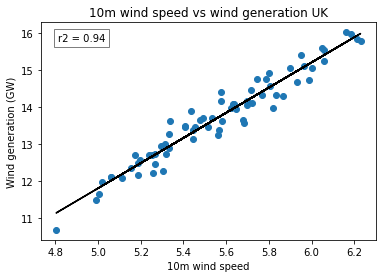

In [31]:
# plot 10m wind speed vs wind generation
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wind_gen",
    title="10m wind speed vs wind generation UK",
    xlabel="10m wind speed",
    ylabel="Wind generation (GW)",
)

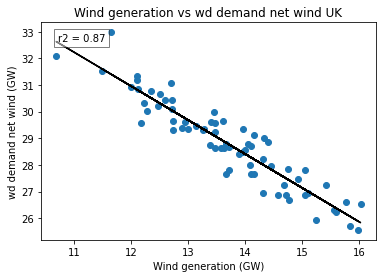

In [32]:
# plot the scatter of wind generation vs wd demand net wind
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="wind_gen",
    y_col="wd_demand_net_wind",
    title="Wind generation vs wd demand net wind UK",
    xlabel="Wind generation (GW)",
    ylabel="wd demand net wind (GW)",
)

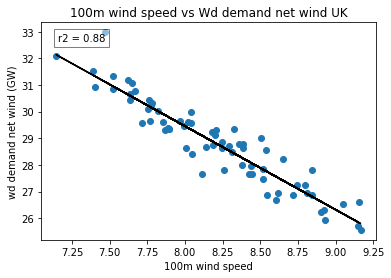

In [33]:
# scatter of 100m wind speed vs demand net wind
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="100m_wind_speed",
    y_col="wd_demand_net_wind",
    title="100m wind speed vs Wd demand net wind UK",
    xlabel="100m wind speed",
    ylabel="wd demand net wind (GW)",
)

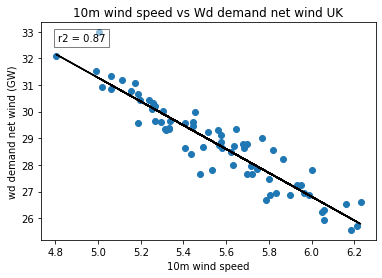

In [34]:
# 10m wind speed vs wd demand net wind
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="wd_demand_net_wind",
    title="10m wind speed vs Wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="wd demand net wind (GW)",
)

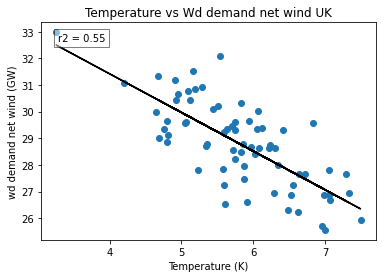

In [35]:
# temperature vs wd demand net wind
plot_scatter_with_fit(
    df=df_full_daily_ONDJFM,
    x_col="t2m_no_detrend",
    y_col="wd_demand_net_wind",
    title="Temperature vs Wd demand net wind UK",
    xlabel="Temperature (K)",
    ylabel="wd demand net wind (GW)",
)

In [36]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def plot_3d_scatter(df, x_col, y_col, z_col, title, xlabel, ylabel, zlabel):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df[x_col], df[y_col], df[z_col])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)

    # Fit a multiple linear regression model
    X = df[[x_col, y_col]]
    y = df[z_col]
    model = LinearRegression().fit(X, y)

    # Calculate the R-squared value
    r2 = model.score(X, y)

    # Print the R-squared value
    print(f'R-squared: {r2:.2f}')

    # Plot the regression plane
    x_range = np.linspace(X[x_col].min(), X[x_col].max(), num=10)
    y_range = np.linspace(X[y_col].min(), X[y_col].max(), num=10)
    x_range, y_range = np.meshgrid(x_range, y_range)
    z_range = model.predict(np.array([x_range.flatten(), y_range.flatten()]).T).reshape(x_range.shape)
    ax.plot_surface(x_range, y_range, z_range, alpha=0.5)

    plt.show()

R-squared: 0.97


/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


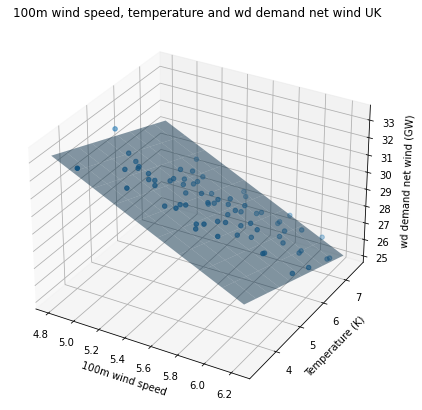

In [37]:
# 3d scatter of 100m wind speed, temperature and wd demand net wind
plot_3d_scatter(
    df=df_full_daily_ONDJFM,
    x_col="10m_wind_speed",
    y_col="t2m_no_detrend",
    z_col="wd_demand_net_wind",
    title="10m wind speed, temperature and wd demand net wind UK",
    xlabel="10m wind speed",
    ylabel="Temperature (K)",
    zlabel="wd demand net wind (GW)",
)

Now we want to test the strength of this MLR fit by providing the model with 10m wind speeds and 2m temperatures over the UK for a given season and getting it to predict the weather-dependent demand net wind.

We can then compare the results of this to our demand net wind variable and see how close they are.

In [38]:
# Fit a multiple linear regression model
# Fit a multiple linear regression model
X = df_full_daily_ONDJFM[["10m_wind_speed", "t2m_no_detrend"]]
y = df_full_daily_ONDJFM["wd_demand_net_wind"]
model = LinearRegression().fit(X, y)

# Calculate the R-squared value
r2 = model.score(X, y)

# Print the R-squared value
print(f'R-squared: {r2:.2f}')

# Predict the z values (i.e., wd_demand_net_wind) for the corresponding x and y values in each row
z_predicted = model.predict(X)

# Print the shape of the z_predicted
print(np.shape(z_predicted))

R-squared: 0.97
(70,)


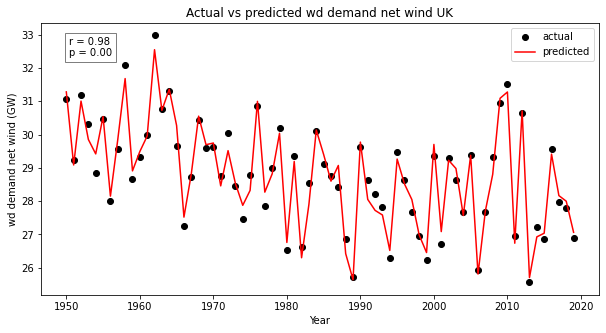

In [39]:
from scipy.stats import pearsonr

# set up a figure
fig = plt.figure(figsize=(10, 5))

# plot the actual wd demand net wind values
plt.scatter(df_full_daily_ONDJFM.index, df_full_daily_ONDJFM["wd_demand_net_wind"], label="actual", color="k")

# plot the predicted wd demand net wind values
plt.plot(df_full_daily_ONDJFM.index, z_predicted, label="predicted", color="r")

# set the title
plt.title("Actual vs predicted wd demand net wind UK")

# calculate the correlation between the actual and predicted values
r, p = pearsonr(df_full_daily_ONDJFM["wd_demand_net_wind"], z_predicted)

# text in the top left with r2
plt.text(
    0.05,
    0.95,
    f"r = {r:.2f}\np = {p:.2f}",
    horizontalalignment="left",
    verticalalignment="top",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
)

# set the x label
plt.xlabel("Year")

# set the y label
plt.ylabel("wd demand net wind (GW)")

# show the legend
plt.legend()

Now import the temperature and wind speed data from DePreSys. It fails the fidelity tests for this test period (1960-1965) but that's kind of expected as we only have 5 observations and 50 model combinations.

We assume, therefore, that it has passed the fidelity tests, and now we are trying to translate the wind speeds and temperatures into demand net wind via our observed relationship.

In [40]:
# Set up the path to the data
csv_dir = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"
sfcwind_fname = "HadGEM3-GC31-MM_sfcWind_United Kingdom_ONDJFM_1960_1965_dcppA-hindcast_Amon.csv"
t2m_fname = "HadGEM3-GC31-MM_tas_United Kingdom_ONDJFM_1960_1965_dcppA-hindcast_Amon.csv"

# Load the data
df_sfcwind = pd.read_csv(os.path.join(csv_dir, sfcwind_fname))

# Load the data
df_t2m = pd.read_csv(os.path.join(csv_dir, t2m_fname))

In [46]:
df_sfcwind.tail()

,init_year,member,lead,sfcWind
7495,1965,9,121,12.318159
7496,1965,9,122,11.984090
7497,1965,9,123,10.053566
7498,1965,9,124,11.320417
7499,1965,9,125,9.731982


In [45]:
# rename the data column for df_sfcwind
df_sfcwind.rename(columns={"data": "sfcWind"}, inplace=True)

# rename the data column for df_t2m
df_t2m.rename(columns={"data": "tas"}, inplace=True)

In [47]:
# merge the dataframes
df = pd.merge(df_sfcwind, df_t2m, on=['init_year', 'member', 'lead'])

In [48]:
df.head()

,init_year,member,lead,sfcWind,tas
0,1960,10,1,11.151278,276.202881
1,1960,10,2,11.545246,274.277990
2,1960,10,3,10.791002,273.459889
3,1960,10,4,10.044464,274.358553
4,1960,10,5,11.279290,273.730867


In [49]:
# convert tas from K to C
df["tas"] = df["tas"] - 273.15

In [53]:
# create a new cf to calculate the means over the ONDJFM
df_new = pd.DataFrame()

# loop over the unique init years and members in df
for init_year in df['init_year'].unique():
    for member in df['member'].unique():
        # extract the model data
        model_data = df[(df['init_year'] == init_year) & (df['member'] == member)]

        # subset to lead values [12, 13, 14, 15, 16, 17] and take the mean
        # first complete ONDJFM season
        model_data = model_data[model_data['lead'].isin([12, 13, 14, 15, 16, 17])]

        mean_tas = model_data['tas'].mean()
        mean_sfcWind = model_data['sfcWind'].mean()

        # create a dataframe this
        model_data_this = pd.DataFrame(
            {
                'init_year': [init_year],
                'member': [member],
                'tas': [mean_tas],
                'sfcWind': [mean_sfcWind]
            }
        )

        df_new = pd.concat([df_new, model_data_this])


In [55]:
df_new.tail()

,init_year,member,tas,sfcWind
0,1965,5,2.112552,10.577661
0,1965,6,1.540891,10.461658
0,1965,7,1.063251,10.056174
0,1965,8,1.695330,10.802726
0,1965,9,1.414509,10.719741


In [56]:
# set up the predictors
X_model = df_new[["sfcWind", "tas"]]

# predict the wd demand net wind
df_new["wd_demand_net_wind_pred"] = model.predict(X_model)

/apps/jasmin/jaspy/miniconda_envs/jaspy3.10/m3-4.9.2/envs/jaspy3.10-m3-4.9.2-r20220721/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- sfcWind
- tas
Feature names seen at fit time, yet now missing:
- 10m_wind_speed
- t2m_no_detrend

  warnings.warn(message, FutureWarning)


In [58]:
df_new.tail()

,init_year,member,tas,sfcWind,wd_demand_net_wind_pred
0,1965,5,2.112552,10.577661,13.329649
0,1965,6,1.540891,10.461658,14.143121
0,1965,7,1.063251,10.056174,15.930461
0,1965,8,1.695330,10.802726,12.811498
0,1965,9,1.414509,10.719741,13.304441


In [59]:
# print the min and max of the predicted wd demand net wind
print(df_new["wd_demand_net_wind_pred"].min())
print(df_new["wd_demand_net_wind_pred"].max())

12.321390576936885
18.29980755598997


In [ ]:
Seems far too low. Perhaps a result of the mean biases in the model. The observed wind speeds are biased low (i.e. ERA5 winds are too still) so demand net wind will be higher as a result. While the observed temperatures are biased high, which will mean reduced winter demand? Winds are likely more of a dominant influence in the model though. Will have to do this with the full data.